<a href="https://colab.research.google.com/github/Umutoniwasepie/Customer_support_chatbot/blob/main/Summative_Customer_support_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer support chatbot

This notebook develops a domain-specific customer support chatbot using T5-small, fine-tuned on the full 26,872-row Bitext Customer Support Dataset. I preprocess the data, train the model, evaluate performance with perplexity and qualitative testing, and deploy it via Streamlit, achieving efficient, natural responses for 27 support intents.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installations

In [ ]:
!pip install datasets -q
!pip install transformers -q
!pip install matplotlib -q
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.6 MB/s eta 0:00:00


## Imports

Imports necessary Python libraries for building, training, and deploying the chatbot.

In [ ]:
# Imports
import torch
from datasets import load_dataset, DatasetDict
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
import streamlit as st
import re

## Dataset Loading and Inspection

Loads the full Bitext Customer Support Dataset from Hugging Face, explores its structure with a sample, and splits it into training (90%) and validation (10%) sets for model training.

In [ ]:
# Load the Bitext Customer Service Dataset
dataset = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")

# Explore the dataset
print(dataset['train'][0])  # Example conversation

split_ratio = 0.9
train_test_split = dataset["train"].train_test_split(test_size=(1 - split_ratio), seed=42)
dataset = DatasetDict({"train": train_test_split["train"], "validation": train_test_split["test"]})

print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

(…)t_Training_Dataset_27K_responses-v11.csv:   0%|          | 0.00/19.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26872 [00:00<?, ? examples/s]

{'flags': 'B', 'instruction': 'question about cancelling order {{Order Number}}', 'category': 'ORDER', 'intent': 'cancel_order', 'response': "I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to assist you."}
DatasetDict({
    train: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 24184
    })
    validation: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 2688
    })
})


### Missing Values Check

Verify the dataset’s data integrity by checking for missing values in ‘instruction’ and ‘response’ fields, ensuring no incomplete records affect training.  

In [ ]:
# Check for missing values in the 'instruction' and 'response' columns
missing_values = dataset['train'].filter(lambda x: x['instruction'] is None or x['response'] is None)

# Display the number of missing values and a sample
print(f"\nNumber of rows with missing values: {len(missing_values)}")
print("\nSample of rows with missing values (if any):")
print(missing_values[:5])  # Show the first 5 rows with missing values

Filter:   0%|          | 0/24184 [00:00<?, ? examples/s]


Number of rows with missing values: 0

Sample of rows with missing values (if any):
{'flags': [], 'instruction': [], 'category': [], 'intent': [], 'response': []}


### Intent Distribution Analysis

Analyse the distribution of intents in the training set to ensure balance.  

In [ ]:
# Check Intent Distribution (Before Tokenization)
intent_counts = {}
for example in dataset["train"]:
    intent = example["intent"]
    intent_counts[intent] = intent_counts.get(intent, 0) + 1
print("Intent Distribution:", intent_counts)

Intent Distribution: {'delete_account': 899, 'payment_issue': 899, 'contact_customer_service': 906, 'check_refund_policy': 889, 'create_account': 900, 'change_order': 901, 'edit_account': 905, 'track_refund': 887, 'complaint': 904, 'track_order': 896, 'newsletter_subscription': 894, 'check_payment_methods': 897, 'set_up_shipping_address': 902, 'switch_account': 901, 'registration_problems': 899, 'review': 891, 'check_invoice': 910, 'change_shipping_address': 881, 'cancel_order': 889, 'delivery_period': 913, 'place_order': 900, 'get_refund': 913, 'check_cancellation_fee': 865, 'delivery_options': 886, 'contact_human_agent': 879, 'recover_password': 893, 'get_invoice': 885}


### Visualization of the intent distribution

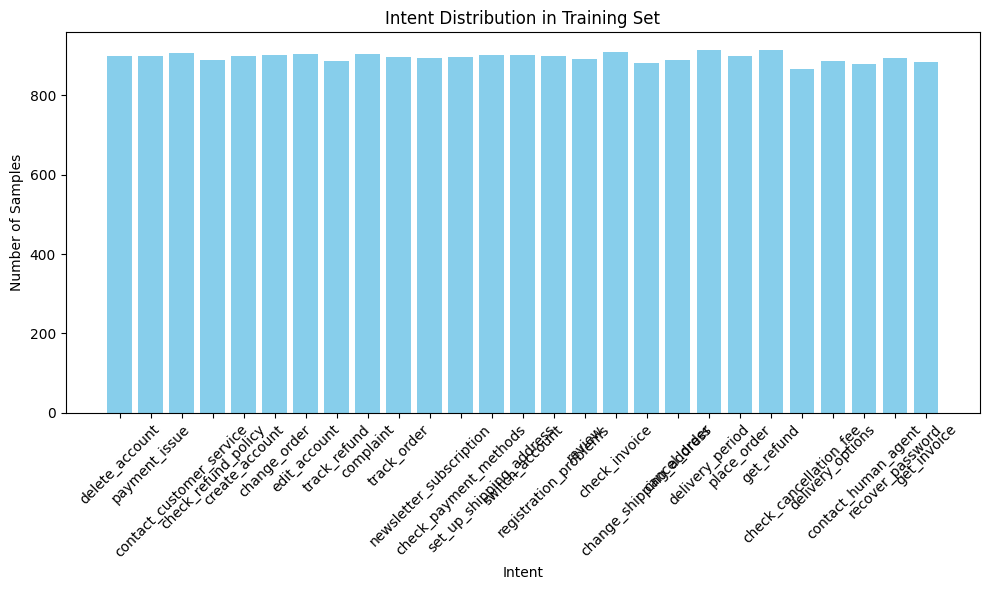

In [ ]:
import matplotlib.pyplot as plt
# Visualization: Intent Distribution Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(intent_counts.keys(), intent_counts.values(), color='skyblue')
plt.title("Intent Distribution in Training Set")
plt.xlabel("Intent")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("intent_distribution.png")
plt.show()

## Data Preprocessing
Implemented text normalization and tokenization functions for the Bitext dataset, preparing it for training.  

In [ ]:
# Preprocessing
def normalize_input(text):
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s\?\.,!]', '', text)
    return text

tokenizer = T5Tokenizer.from_pretrained("t5-small")
def preprocess_function(examples):
    inputs = [f"generate response for intent: {intent}: {normalize_input(instr)}"
              for intent, instr in zip(examples["intent"], examples["instruction"])]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["response"], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
tokenized_dataset.save_to_disk("./tokenized_dataset")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/24184 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2688 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24184 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2688 [00:00<?, ? examples/s]

## Model Training and fine-tuning


In [ ]:
# Load T5-small model
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Define training arguments optimized for Colab memory usage
training_args = TrainingArguments(
    output_dir="./results",  # Directory for saving model checkpoints
    num_train_epochs=3,  # Three epochs for optimal balance of performance and efficiency
    per_device_train_batch_size=8,  # Batch size constrained by Colab memory
    per_device_eval_batch_size=16,  # Larger eval batch for faster validation
    warmup_steps=100,  # Gradual learning rate increase for stability
    weight_decay=0.01,  # Regularization to prevent overfitting
    learning_rate=2e-5,  # Baseline learning rate for initial training
    logging_dir="./logs",  # Directory for training logs
    logging_steps=10,  # Log progress every 10 steps
    save_steps=200,  # Save checkpoints every 200 steps
    save_total_limit=1,  # Keep only the best model
    eval_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",  # Save after each epoch
    load_best_model_at_end=True,  # Use the best model based on validation loss
    fp16=True if torch.cuda.is_available() else False,  # Mixed precision for memory efficiency
    gradient_accumulation_steps=2,  # Effective batch size of 16 for memory optimization
    report_to="none"  # Disable logging to external services
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
)

# Train model
trainer.train()

# Evaluate and compare learning rates
baseline_loss = trainer.evaluate()["eval_loss"]

# Fine-tune with a higher learning rate
training_args.learning_rate = 5e-5
trainer = Trainer(model=model, args=training_args, train_dataset=tokenized_dataset["train"], eval_dataset=tokenized_dataset["validation"])
trainer.train()
tuned_loss = trainer.evaluate()["eval_loss"]

# Save final model
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")

# Print training results
print(f"Baseline (2e-5) Loss: {baseline_loss:.2f}")
print(f"Tuned (5e-5) Loss: {tuned_loss:.2f}")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.661300,1.454191
2,1.490000,1.263685


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Epoch,Training Loss,Validation Loss
1,1.207900,1.051186
2,1.140800,0.962882


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Baseline (2e-5) Loss: 1.26
Tuned (5e-5) Loss: 0.96


### Loss Visualization
Visualizes the training loss comparison between baseline (2e-5) and tuned (5e-5) learning rates, saving loss_comparison.png for reporting.  

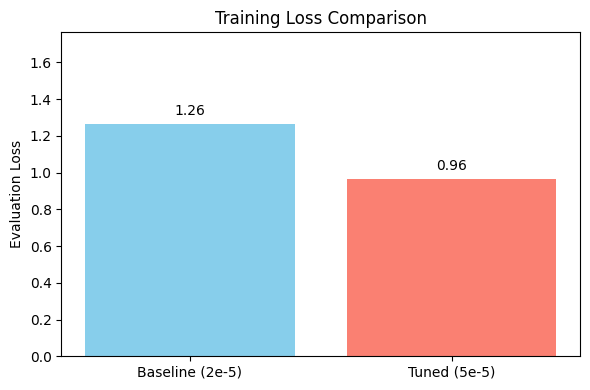

In [ ]:
# Loss values
losses = {"Baseline (2e-5)": baseline_loss, "Tuned (5e-5)": tuned_loss}

# Plot loss comparison
plt.figure(figsize=(6, 4))
plt.bar(losses.keys(), losses.values(), color=['skyblue', 'salmon'])
plt.title("Training Loss Comparison")
plt.ylabel("Evaluation Loss")
plt.ylim(0, max(losses.values()) + 0.5)
for i, v in enumerate(losses.values()):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.savefig("loss_comparison.png")
plt.show()

## Performance Evaluation

Evaluates the T5-small chatbot’s performance using perplexity and qualitative testing, testing three sample queries to demonstrate functionality.  

In [ ]:
# -----------------------------------
# Subsection 4: Performance Evaluation
# -----------------------------------
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import re

# Load final model
tokenizer = T5Tokenizer.from_pretrained("./final_model")
model = T5ForConditionalGeneration.from_pretrained("./final_model")

def normalize_input(text):
    """Normalize text: lowercase, strip spaces, remove special chars."""
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s\?\.,!]', '', text)
    return text

def capitalize_response(response):
    """Capitalize the first letter of sentences for readability."""
    sentences = response.split(". ")
    unique_sentences = []
    for s in sentences:
        if s and s not in unique_sentences:
            unique_sentences.append(s.capitalize())
    return ". ".join(unique_sentences)

def test_query(query):
    """Test chatbot response for a given query."""
    query_lower = normalize_input(query)
    input_text = f"generate response: Current query: {query_lower}"
    input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).input_ids
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_length=200,
            temperature=0.8,
            top_k=70,
            repetition_penalty=1.5
        )
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return capitalize_response(response)

# Compute perplexity from tuned loss (0.96)
perplexity = torch.exp(torch.tensor(0.96)).item()
print(f"Perplexity: {perplexity:.2f}")

# Qualitative testing with sample queries (including a small test query)
test_queries = [
    "cancel order",
    "track refund status",
    "Help me resolve the payment issue"
]
for q in test_queries:
    print(f"Query: {q}\nResponse: {test_query(q)}\n")

Perplexity: 2.61


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `70` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Query: cancel order
Response: I'm here to assist you in canceling your order. To cancel your order, please follow these steps: 1. Log in to your account on our website. 2. Navigate to the "my orders" or "account" section. 3. Look for the option to cancel your order. 4. Click on the order to proceed with the cancellation request. 5. Select the order that you would like to cancel and click on it. If you encounter any difficulties or have further questions, feel free to let me know.

Query: track refund status
Response: I'm here to assist you in tracking the status of your refund. To provide you with accurate information, could you please provide me with more details about the specific refund status? this will enable me to provide you with the most up-to-date information.

Query: Help me resolve the payment issue
Response: I'm here to assist you in resolving the payment issue. Your feedback is invaluable to us, and we appreciate your patience as we work towards a resolution. To better ass

## Streamlit Deployment

Here, I deploy the T5-small chatbot with Streamlit, creating an intuitive interface for customer support queries, using intent identification for response generation.  

In [40]:
from pyngrok import ngrok

# Write Streamlit app to a file
with open("app.py", "w") as f:
    f.write('''
import streamlit as st

# Import the necessary functions
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import re

# Load the model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("./final_model")
model = T5ForConditionalGeneration.from_pretrained("./final_model")

def normalize_input(text):
    text = text.lower().strip()
    text = re.sub(r'\\s+', ' ', text)
    text = re.sub(r'[^\w\\s\\?.,!]', '', text)
    return text

def capitalize_response(response):
    sentences = response.split(". ")
    unique_sentences = []
    for s in sentences:
        if s and s not in unique_sentences:
            unique_sentences.append(s.capitalize())
    return ". ".join(unique_sentences)

def test_query(query):
    query_lower = normalize_input(query)
    input_text = f"generate response: Current query: {query_lower}"
    input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).input_ids
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_length=200,
            temperature=0.8,
            top_k=70,
            repetition_penalty=1.5
        )
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return capitalize_response(response)

# Streamlit app layout
st.title("Customer Support Chatbot")
user_input = st.text_input("You:", "")

if st.button("Send"):
    response = test_query(user_input)
    st.write(f"**Bot:** {response}")
''')


In [21]:
!pip install pyngrok -q

In [41]:
from pyngrok import ngrok

!ngrok authtoken 2tUTYT5olgKUvFeixn1H1EErgmQ_3ysCErHhLmTsuNeZ6tLta # Replace with your actual token
public_url = ngrok.connect(8501)
print(f"Streamlit app running at: {public_url}")

# Run Streamlit
!streamlit run app.py &>/dev/null &

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit app running at: NgrokTunnel: "https://0ff3-34-126-115-169.ngrok-free.app" -> "http://localhost:8501"
